### Assingment 2 - NLP 243 

Slot Tagging Utterances 

*Parsa Mazaheri*

In [171]:
!pip install contractions seqeval
!mkdir /content/data
!mkdir /content/output

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/content/data’: File exists
mkdir: cannot create directory ‘/content/output’: File exists


🔴 *Drop `hw2_train.csv` and `hw2_test.csv` from the zip file in the `data` folder that has been creatd just now.*  🔴

In [2]:
# Imports
import os
cwd = os.getcwd()

import os
import re
import json

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from seqeval.metrics import f1_score
from seqeval.scheme import IOB2

from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import spacy
from spacy.tokenizer import Tokenizer
import contractions

import seaborn as sns
import operator
from itertools import islice

from sklearn.model_selection import train_test_split
from tqdm import tqdm



/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
# Set device = CUDA if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: ', device)

Device:  cpu


In [5]:
# Reading CSV File into Pandas DataFrame

# Reading Train Dataset into DataFrame
dataF = pd.read_csv(cwd + '/data/hw2_train.csv', index_col = 0)
dataF.columns = ['texts', 'tags']
print('Train Set Shape:', dataF.shape)

# Removing unequal texts and tags from train dataset
list_of_dict = []
for idx, row in dataF.iterrows():
    temp_dict = {}
    len_text = len(row['texts'].split())
    len_tag = len(row['tags'].split())
    if(len_text == len_tag):
        temp_dict['texts'] = row['texts']
        temp_dict['tags'] = row['tags']
        list_of_dict.append(temp_dict)
df = pd.DataFrame.from_dict(list_of_dict)
print('Train Set with unequal rows removed Shape: ', df.shape)

# Reading Test Dataset into DataFrame
test_data = pd.read_csv(cwd + '/data/hw2_test.csv', index_col = 0)
test_data.columns = ['texts']
print('Test Set Shape:', test_data.shape)


Train Set Shape: (2312, 2)
Train Set with unequal rows removed Shape:  (2254, 2)
Test Set Shape: (981, 1)


In [24]:
# Splitting the Training dataset into the Training set and Validation set
train_data, val_data = train_test_split(df,
                                        random_state = 32, 
                                        test_size = 0.25, 
                                        shuffle = True)
print('Train Data Shape: ', train_data.shape)
print('Val Data Shape: ', val_data.shape)

Train Data Shape:  (1690, 2)
Val Data Shape:  (564, 2)


In [7]:
! wget https://nlp.stanford.edu/data/glove.6B.zip -P /content/
!unzip /content/glove.6B.zip -d /content/data/

--2022-12-12 17:02:11--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-12 17:02:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/content/glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2022-12-12 17:04:51 (5.17 MB/s) - ‘/content/glove.6B.zip’ saved [862182613/862182613]

Archive:  /content/glove.6B.zip
  inflating: /content/data/glove.6B.50d.txt  
  inflating: 

In [25]:
# Pre-Trained GloVe Word Embeddings
print("> Loading glove embeddings ...")
glove = pd.read_csv(
    cwd + '/data/glove.6B.300d.txt', 
    sep = ' ', 
    quoting = 3, header = None, index_col = 0)
glove_embedding = {key: val.values for key, val in glove.T.items()}
print('GloVe Embeddings Length: ', len(glove_embedding))

print()

# Create NumPy Array for Vocab and Emeddings
print("> Creating Vocab and embeddings ...")
vocab = list(glove_embedding.keys())
embeddings = list(glove_embedding.values())

vocab = np.array(vocab)
embeddings = np.array(embeddings)

# Insert '<pad>' and '<unk>' tokens at start of vocab
vocab = np.insert(vocab, 0, '<pad>')
vocab = np.insert(vocab, 1, '<unk>')
print('Vocab Shape: ', vocab.shape)

# Insert embeddings for pad and unk tokens at top of embeddings
emb_pad = np.zeros((1, embeddings.shape[1]))
emb_unk = np.mean(embeddings, axis = 0, keepdims = True)
embeddings = np.vstack((emb_pad, emb_unk, embeddings))
print('Embeddings Shape: ', embeddings.shape)

> Loading glove embeddings ...
GloVe Embeddings Length:  399998

> Creating Vocab and embeddings ...
Vocab Shape:  (400000,)
Embeddings Shape:  (400000, 300)


In [26]:
# Dictionary for words
word2idx = { term: idx for idx, term in enumerate(vocab) }
word2idx['<pad>'] = 0
word2idx['<unk>'] = 1
idx2word = { idx: word for word,idx in word2idx.items() }

# Dicitionary for tags
tag_set = set()
tag_count_dict = {}
for index, row in df.iterrows():
    temp = row['tags'].split()
    for item in temp:
        tag_set.add(item)
        if item not in tag_count_dict:
            tag_count_dict[item] = 1
        else:
            tag_count_dict[item] = tag_count_dict[item] + 1

tag2idx = { tag: idx for idx, tag in enumerate(tag_set) }
idx2tag = { idx: word for word, idx in tag2idx.items() }

print('> Idx to Tag Dict: ', idx2tag)

TAG_COUNT = len(tag2idx)
print('Num Count: \n', TAG_COUNT)


> Idx to Tag Dict:  {0: 'B_country', 1: 'B_mpaa_rating', 2: 'B_cast', 3: 'I_release_year', 4: 'I_producer', 5: 'B_char', 6: 'B_director', 7: 'B_movie', 8: 'I_country', 9: 'I_subject', 10: 'O', 11: 'B_language', 12: 'I_person', 13: 'I-movie', 14: 'I_mpaa_rating', 15: 'I_char', 16: 'I_language', 17: 'B_release_year', 18: 'I_cast', 19: 'I_director', 20: 'B_subject', 21: 'B_producer', 22: 'I_movie', 23: 'I_genre', 24: 'B_location', 25: 'B_genre', 26: 'B_person'}
Num Count: 
 27


In [27]:
# Class for DataLoader
class DataSet(Dataset):

    def __init__(self, data: pd.DataFrame):
        en = English()
        self.data = data
        self.texts = self.data['texts']
        if 'tags' in self.data.columns:
            self.tags = self.data['tags']
        self.tokenizer = Tokenizer(en.vocab)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx: int):
        # Enoding Text
        text = self.texts.iloc[idx]
        encoded_text = self.encode_text(text)
        
        # Encoding Tags if they exist
        if 'tags' in self.data.columns:
            tag = self.tags.iloc[idx]
            encoded_tag = self.encode_tag(tag)
            return encoded_text, encoded_tag 
        else:
            return encoded_text
        
    # Tokenize    
    def tokenize(self, text: str):
        return [i.text for i in self.tokenizer(text)]
    
    # Encode Text
    def encode_text(self, text):
        text_list = [word for word in self.tokenize(text)]
        text_vector = []
        for word in text_list:
            if word in word2idx:
                text_vector.append(word2idx[word])
            else:
                text_vector.append(1)
        return text_vector
    
    # Enocde Tags
    def encode_tag(self, tag):
        tag_list = [word for word in self.tokenize(tag)]
        tag_vector = [tag2idx[word] for word in tag_list]
        return tag_vector

In [28]:

print('> Converting Data to Dataset ...')
train_ds = DataSet(train_data)
val_ds = DataSet(val_data)
test_ds = DataSet(test_data)


print(train_ds[0])
print(train_ds[1])

> Converting Data to Dataset ...
([275, 287, 2, 3227, 12, 2, 1007], [10, 10, 10, 10, 10, 10, 10])
([40, 17, 8, 21997], [10, 10, 10, 7])


In [29]:
# Custom Collate function
def custom_collate_fn(batch):
    if isinstance(batch[0], list):
        texts_tensor = [torch.tensor(text) for text in batch]

        lengths = [len(text) for text in batch]
        lengths = torch.tensor(lengths)

        texts_padded = pad_sequence(texts_tensor, batch_first = True, padding_value = 0)

        return texts_padded, lengths

    else:
        texts, tags = zip(*batch)

        texts_tensor = [torch.tensor(text) for text in texts]
        tags_tensor = [torch.tensor(tag) for tag in tags]

        lengths = [len(text) for text in texts]
        lengths = torch.tensor(lengths)

        texts_padded = pad_sequence(texts_tensor, batch_first = True, padding_value = 0)
        tags_padded = pad_sequence(tags_tensor, batch_first = True, padding_value = 0)

        return texts_padded, tags_padded, lengths

BATCH_SIZE = 32

# PyTorch Data Loaders
train_loader = DataLoader(
    train_ds, batch_size = BATCH_SIZE, shuffle = True, collate_fn = custom_collate_fn)

val_loader = DataLoader(
    val_ds, batch_size = BATCH_SIZE, shuffle = True, collate_fn = custom_collate_fn)

test_loader = DataLoader(
    test_ds, batch_size = 1, shuffle = False, collate_fn = custom_collate_fn)


In [87]:
# Bi-LSTM Model
# LSTM Model
class LSTM(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        # Pre-Trained Embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float())
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True)
        num_directions = 2 if bidirectional else 1
        # Dense layers to predict
        self.fc1 = nn.Linear(hidden_dim * num_directions, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # Dropout to improve with regularization
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, x_lengths):
        # Embedding Layer
        embedded = self.embedding(x)
        # Dropout Layer before LSTM Layer
        embedded = self.dropout(embedded)
        # Packed Sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, x_lengths, batch_first = True, enforce_sorted = False)
        # LSTM Layer
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # Unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first = True)
        # 1st Fully Connected Layer
        output = self.fc1(output)
        # Dropout Layer before Output
        output = self.dropout(output)
        # 2nd Fully Connected Layer
        output = self.fc2(output)
        return output



# GRU Model
class GRU(nn.Module):
        
        def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
            super().__init__()
            # Pre-Trained Embeddings
            self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float())
            # GRU layer
            self.gru = nn.GRU(embedding_dim, 
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True)
            num_directions = 2 if bidirectional else 1
            # Dense layers to predict
            self.fc1 = nn.Linear(hidden_dim * num_directions, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, output_dim)
            # Dropout to improve with regularization
            self.dropout = nn.Dropout(dropout)
            
        def forward(self, x, x_lengths):
            # Embedding Layer
            embedded = self.embedding(x)
            # Dropout Layer before GRU Layer
            embedded = self.dropout(embedded)
            # Packed Sequence
            packed_embedded = nn.utils.rnn.pack_padded_sequence(
                embedded, x_lengths, batch_first = True, enforce_sorted = False)
            # GRU Layer
            packed_output, hidden = self.gru(packed_embedded)
            # Unpack sequence
            output, output_lengths = nn.utils.rnn.pad_packed_sequence(
                packed_output, batch_first = True)
            # 1st Fully Connected Layer
            output = self.fc1(output)
            # Dropout Layer before Output
            output = self.dropout(output)
            # 2nd Fully Connected Layer
            output = self.fc2(output)
            return output



# MLP Model
class MLP(nn.Module):
        
        def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
            super().__init__()
            # Pre-Trained Embeddings
            self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float())
            # Dense layers to predict
            self.fc1 = nn.Linear(embedding_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            self.fc3 = nn.Linear(hidden_dim, output_dim)
            # Dropout to improve with regularization
            self.dropout = nn.Dropout(dropout)
            
        def forward(self, x, x_lengths):
            # Embedding Layer
            embedded = self.embedding(x)
            # Flatten
            embedded = embedded.view(embedded.shape[0], -1)
            # 1st Fully Connected Layer
            output = self.fc1(embedded)
            # Dropout Layer before Output
            output = self.dropout(output)
            # 2nd Fully Connected Layer
            output = self.fc2(output)
            # Dropout Layer before Output
            output = self.dropout(output)
            # 3rd Fully Connected Layer
            output = self.fc3(output)
            return output

In [160]:
torch.manual_seed(32)

# Model Hyper-parameters
EMBEDDING_DIM = embeddings.shape[1]
HIDDEN_DIM = 20
OUTPUT_DIM = TAG_COUNT
NUM_LAYERS = 3
BIDIRECTION = True
DROPOUT = 0.2
LEARNING_RATE = 0.01
MODEL_TYPE = 'lstm'  


In [161]:

def get_model(model) -> nn.Module:

    if model == 'mlp':
        return MLP(
            EMBEDDING_DIM,
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            NUM_LAYERS, 
            DROPOUT).to(device)
    
    elif model == 'gru':
        return GRU(
            EMBEDDING_DIM,
            HIDDEN_DIM, 
            OUTPUT_DIM,
            NUM_LAYERS, 
            BIDIRECTION, 
            DROPOUT).to(device)

    elif model == 'lstm':
        return LSTM(
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            NUM_LAYERS, 
            BIDIRECTION, 
            DROPOUT).to(device)

model = get_model(
    model=MODEL_TYPE
)

print(model)

LSTM(
  (embedding): Embedding(400000, 300)
  (lstm): LSTM(300, 20, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=40, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=27, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [162]:
def squeezed_list(my_list):
    temp_list = [int(element) for element in my_list]
    return temp_list  

def slice_list(my_list, slice_increment):
    return [my_list[i : i + slice_increment] for i in range(0, len(my_list), slice_increment)]

def convert_idx_to_tags(lol, isTensor):
    iob_list = []
    for list_element in lol:
        if (isTensor):
            list_element = list_element.numpy() 
        iob = [idx2tag[index] for index in list_element]
        iob_list.append(iob)
    return iob_list

In [163]:
# Model Train Function
def train(loader, model, optimizer, loss_fn):
    model.train().to(device)
    losses = []
    pbar = tqdm(loader)
    for x, y, lengths in pbar:
        optimizer.zero_grad()
        
        # Calculate y_pred
        y_pred = model(x, lengths)
        
        # Convert y_pred to 2D Tensor
        y_pred = y_pred.view(-1, y_pred.shape[-1])
        # Convert y_pred to 1D Tensor
        y = torch.flatten(y)
        
        loss = loss_fn(y_pred, y)
        pbar.set_postfix({'Loss': loss.item()})
        losses.append(loss.item())
        
        # Calculate gradients for w/b
        loss.backward()  
        # Update weights according to optimizer rules
        optimizer.step()          
    return round((sum(losses) / len(losses)), 4)


# Model Evaluate Function
def evaluate(loader, model, loss_fn, score_fn):
    model.eval()
    losses = []
    for x, y, lengths in tqdm(loader):
        y_pred = model(x, lengths)
        
        max_len = x.shape[1]
              
        # Convert y_pred to 2D Tensor
        y_pred = y_pred.view(-1, y_pred.shape[-1])
        # Convert y_pred to 1D Tensor
        y = torch.flatten(y)
        
        loss = loss_fn(y_pred, y)
        losses.append(loss.item())
        
        tags_iob = convert_idx_to_tags(slice_list(y, max_len), True)

        # Get the index of the max probability
        max_preds = y_pred.argmax(dim = 1, keepdim = True) 
        
        predictions_iob = convert_idx_to_tags(
            slice_list((squeezed_list(max_preds)), max_len), False)
    
    score = score_fn(tags_iob, predictions_iob, scheme = IOB2)
    return tags_iob, predictions_iob, round((sum(losses) / len(losses)), 4), round(score, 4)

In [164]:
# disable seqeval warnings
import warnings
warnings.filterwarnings('ignore')

In [165]:
# Model Training on Train dataset and Evaluation on Validation dataset
optimizer = torch.optim.AdamW(
    model.parameters(), lr = LEARNING_RATE
    )
loss_fn = nn.CrossEntropyLoss().to(device)
score_fn = f1_score

train_losses, val_losses, f1_scores = [], [], []
N_EPOCHS = 20
best_acc = 0
PATH = f'output/best-model.pt'

for epoch in range(N_EPOCHS):
    # Model Training
    train_loss = train(train_loader, model, optimizer, loss_fn)
    train_losses.append(train_loss)
    print('Train Loss: ', train_loss)
    
    # Model Evaluation
    tags, predictions, val_loss, accuracy = evaluate(
        val_loader, model, loss_fn, score_fn
        )
    val_losses.append(val_loss)
    f1_scores.append(accuracy)
    print('Val Accuracy: ', accuracy)
    print('Val Loss: ', val_loss)
    
    # Save model if Validation F1_Score is greather than 75%
    if accuracy > best_acc and accuracy > 0.75:
        torch.save(model.state_dict(), PATH)

100%|██████████| 53/53 [00:02<00:00, 22.80it/s, Loss=0.476]


Train Loss:  1.3429


100%|██████████| 18/18 [00:00<00:00, 59.79it/s]


Val Accuracy:  0.809
Val Loss:  0.4596


100%|██████████| 53/53 [00:02<00:00, 22.68it/s, Loss=0.395]


Train Loss:  0.3627


100%|██████████| 18/18 [00:00<00:00, 49.81it/s]


Val Accuracy:  0.931
Val Loss:  0.2823


100%|██████████| 53/53 [00:02<00:00, 22.71it/s, Loss=0.213]


Train Loss:  0.2278


100%|██████████| 18/18 [00:00<00:00, 65.00it/s]


Val Accuracy:  0.9107
Val Loss:  0.186


100%|██████████| 53/53 [00:02<00:00, 23.35it/s, Loss=0.243]


Train Loss:  0.1681


100%|██████████| 18/18 [00:00<00:00, 58.64it/s]


Val Accuracy:  0.9622
Val Loss:  0.1679


100%|██████████| 53/53 [00:02<00:00, 22.98it/s, Loss=0.12]


Train Loss:  0.1528


100%|██████████| 18/18 [00:00<00:00, 62.84it/s]


Val Accuracy:  0.9368
Val Loss:  0.1519


100%|██████████| 53/53 [00:02<00:00, 22.96it/s, Loss=0.141]


Train Loss:  0.1265


100%|██████████| 18/18 [00:00<00:00, 66.53it/s]


Val Accuracy:  0.9213
Val Loss:  0.1419


100%|██████████| 53/53 [00:02<00:00, 23.47it/s, Loss=0.186]


Train Loss:  0.1152


100%|██████████| 18/18 [00:00<00:00, 59.70it/s]


Val Accuracy:  0.9843
Val Loss:  0.1346


100%|██████████| 53/53 [00:02<00:00, 23.04it/s, Loss=0.117]


Train Loss:  0.1015


100%|██████████| 18/18 [00:00<00:00, 60.66it/s]


Val Accuracy:  0.9427
Val Loss:  0.1303


100%|██████████| 53/53 [00:02<00:00, 23.07it/s, Loss=0.138]


Train Loss:  0.0915


100%|██████████| 18/18 [00:00<00:00, 60.81it/s]


Val Accuracy:  0.9585
Val Loss:  0.1255


100%|██████████| 53/53 [00:02<00:00, 22.49it/s, Loss=0.0882]


Train Loss:  0.0846


100%|██████████| 18/18 [00:00<00:00, 63.83it/s]


Val Accuracy:  0.9603
Val Loss:  0.1256


100%|██████████| 53/53 [00:02<00:00, 22.89it/s, Loss=0.067]


Train Loss:  0.075


100%|██████████| 18/18 [00:00<00:00, 63.58it/s]


Val Accuracy:  0.9878
Val Loss:  0.1087


100%|██████████| 53/53 [00:02<00:00, 23.02it/s, Loss=0.112]


Train Loss:  0.0719


100%|██████████| 18/18 [00:00<00:00, 63.52it/s]


Val Accuracy:  0.9858
Val Loss:  0.119


100%|██████████| 53/53 [00:02<00:00, 23.09it/s, Loss=0.0507]


Train Loss:  0.0657


100%|██████████| 18/18 [00:00<00:00, 57.94it/s]


Val Accuracy:  0.9531
Val Loss:  0.1053


100%|██████████| 53/53 [00:02<00:00, 22.29it/s, Loss=0.0528]


Train Loss:  0.0606


100%|██████████| 18/18 [00:00<00:00, 63.96it/s]


Val Accuracy:  0.9856
Val Loss:  0.1159


100%|██████████| 53/53 [00:02<00:00, 22.50it/s, Loss=0.111]


Train Loss:  0.0562


100%|██████████| 18/18 [00:00<00:00, 64.74it/s]


Val Accuracy:  0.9852
Val Loss:  0.1306


100%|██████████| 53/53 [00:02<00:00, 21.44it/s, Loss=0.0437]


Train Loss:  0.0512


100%|██████████| 18/18 [00:00<00:00, 59.63it/s]


Val Accuracy:  0.9754
Val Loss:  0.108


100%|██████████| 53/53 [00:03<00:00, 15.66it/s, Loss=0.057]


Train Loss:  0.0498


100%|██████████| 18/18 [00:00<00:00, 65.89it/s]


Val Accuracy:  0.9933
Val Loss:  0.1006


100%|██████████| 53/53 [00:02<00:00, 22.42it/s, Loss=0.0276]


Train Loss:  0.0434


100%|██████████| 18/18 [00:00<00:00, 58.25it/s]


Val Accuracy:  0.9745
Val Loss:  0.123


100%|██████████| 53/53 [00:02<00:00, 22.02it/s, Loss=0.046]


Train Loss:  0.0432


100%|██████████| 18/18 [00:00<00:00, 62.36it/s]


Val Accuracy:  0.9773
Val Loss:  0.1078


100%|██████████| 53/53 [00:03<00:00, 17.63it/s, Loss=0.0595]


Train Loss:  0.0429


100%|██████████| 18/18 [00:00<00:00, 33.17it/s]


Val Accuracy:  0.9789
Val Loss:  0.1106


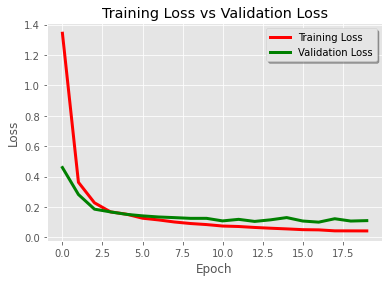

In [166]:
epochs = np.arange(N_EPOCHS)  

plt.style.use('ggplot')
plt.plot(epochs, train_losses, label = "Training Loss", color = "red", linewidth = '3')
plt.plot(epochs, val_losses, label = "Validation Loss", color = "green", linewidth = '3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss', color = 'black')
plt.legend(shadow = True)
plt.savefig('output/train_vs_val_loss_plot.png')

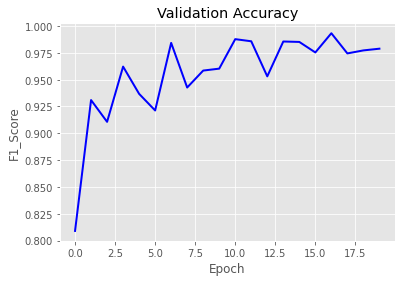

In [167]:
# Validation Accuracy Plot
plt.plot(epochs, f1_scores, color = 'blue', linewidth = '2')
plt.xlabel('Epoch')
plt.ylabel('F1_Score')
plt.title('Validation Accuracy', color = 'black')
plt.savefig('output/f1_accuracy_plot.png')

In [168]:
# Load the saved model
saved_model = LSTM(EMBEDDING_DIM, 
                   HIDDEN_DIM, 
                   OUTPUT_DIM, 
                   NUM_LAYERS, 
                   BIDIRECTION, 
                   DROPOUT).to(device)

saved_model.load_state_dict(torch.load(PATH))
saved_model.eval()

LSTM(
  (embedding): Embedding(400000, 300)
  (lstm): LSTM(300, 20, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=40, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=27, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [169]:
# Model Predict Function
def predict(loader, model):
    predictions = []
    for x, lengths in tqdm(loader):
        with torch.no_grad():
            y_pred = saved_model.forward(x, lengths)
            
            max_len = x.shape[1]

            # Convert y_pred to 2D Tensor
            y_pred = y_pred.view(-1, y_pred.shape[-1])

            max_preds = y_pred.argmax(dim = 1, keepdim = True) # Get the index of the max probability
            predictions_iob = convert_idx_to_tags(slice_list((squeezed_list(max_preds)), max_len), False)
            predictions.append(predictions_iob)
    
    return predictions

predicted_tags = predict(test_loader, saved_model)
predicted_tags = np.array(predicted_tags)
predicted_tags = predicted_tags.squeeze().tolist()

100%|██████████| 981/981 [00:02<00:00, 448.37it/s]


In [170]:
# Creating Dictionary of Predictions
list_of_dict = []
for i in range(len(predicted_tags)):
    temp_dict = {}
    temp_dict["ID"] = i
    temp_dict["IOB Slot tags"] = ' '.join(predicted_tags[i])
    list_of_dict.append(temp_dict)

# Converting Dictionary to CSV and compress it for submission to CodaLab
tags_df = pd.DataFrame.from_dict(list_of_dict)
tags_df.to_csv('output/submission.csv.zip', compression = 'zip', index = False)
print(tags_df)

      ID                                      IOB Slot tags
0      0                                        O O B_movie
1      1                          O O O O O B_movie I_movie
2      2                        O O O O O O B_movie I_movie
3      3                                      O O O B_movie
4      4                                      O O O B_movie
..   ...                                                ...
976  976        O O B_movie I_movie I_movie I_movie I_movie
977  977                            O B_movie I_movie O O O
978  978                O O O O O O B_producer I_producer O
979  979  O O B_cast I_person O O O O I_movie I_movie I_...
980  980                   O O B_director O O O O B_country

[981 rows x 2 columns]
